 <img width="60px" style="float: right;" src="https://xmks.s3.amazonaws.com/2020/X-Blue.png">
 
 # Digital Cities - Water Utilities - Flood Prediction Model
 
 ---
 **By Jaun van Heerden**
 
In the realm of urban water management, forecasting flood events with high precision is critical for safeguarding infrastructure, managing resources, and protecting communities. 

The ability to predict a "critical event" means anticipating and preparing for flood events with the utmost accuracy. This XMPro Notebook applies a machine learning approach, utilizing Support Vector Regression (SVR), to predict the probability of flood events in an urban setting. 

By analyzing historical weather data and utilizing real-time environmental monitoring, we aim to enhance flood prediction models, offering a valuable tool for water utilities and disaster response teams in their efforts to mitigate the impacts of floods in urban areas.
 

# Glossary
1. **[Load in and Check Data](#LoadCleanedData)**
2. **[Feature Engineering](#FeatureEngineering)**
3. **[Results](#Results)**
4. **[Discussion](#Discussion)**
5. **[Save Model](#SaveModel)**
6. **[Feature Weights](#FeatureWeights)**

In [17]:
import pandas as pd
import numpy as np
from pprint import pprint

<a id='LoadCleanedData'></a>
## 1. Load in and Check Data

Proper data handling is the cornerstone of effective machine learning. The initial step in our flood prediction model involves loading and examining the cleaned dataset. This ensures the integrity and quality of the data before it enters the feature engineering and model training phases.

Here's how we proceed:

1. **Load the Dataset**: We begin by importing the dataset from a CSV file, which contains historical weather data pertinent to flood prediction. This data has already undergone preliminary cleaning to remove any irrelevant entries and correct anomalies.

2. **Identify Relevant Features**: The next step is to isolate the features that have the most influence on flood events. These include various meteorological parameters such as temperature, humidity, precipitation, and others that are closely linked to flood occurrences.

3. **Mark Known Flood Events**: We enhance the dataset by marking the dates of known flood events. This enriches our data, providing clear targets for our predictive models to learn from.

4. **Inspect the Data**: A cursory inspection of the first few entries, as well as the entries on known flood dates, gives us a snapshot of our dataset's structure and the marked flood events.

This structured approach to data loading and inspection establishes a robust foundation for the subsequent steps in our predictive modeling process.


In [14]:
# Load the datasets
file_path = 'Data/singapore 2011-11-01 to 2013-10-01.csv'
data = pd.read_csv(file_path)

# Relevant features for flood prediction
relevant_features = ['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']

# Isolating the relevant features
flood_data = data[relevant_features]

# Marking the known flood events
# Convert 'datetime' to datetime object for easy comparison
flood_data['datetime'] = pd.to_datetime(flood_data['datetime'])

# Known flood dates
flood_dates = ['2011-12-23', '2013-09-05']

# Adding a new column 'flood_event' to mark the days of known flood events
flood_data['flood_event'] = flood_data['datetime'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in flood_dates else 0)

# Display the modified dataset
#flood_data.head(), 
flood_data[flood_data['flood_event'] == 1]  # Displaying the entries for the flood days as well


/tmp/ipykernel_202/4232436417.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_data['datetime'] = pd.to_datetime(flood_data['datetime'])


,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,flood_event
52,2011-12-23,29.0,24.8,26.4,34.8,24.8,27.9,24.9,92.0,1.042,...,4,NaN,2011-12-23T07:01:59,2011-12-23T19:04:46,0.94,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"48698099999,48679099999,WSAP,WSSS,48694099999,...",1
674,2013-09-05,27.2,24.5,25.9,31.0,24.5,26.2,24.2,90.3,21.878,...,5,NaN,2013-09-05T06:59:21,2013-09-05T19:07:17,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"48698099999,48679099999,WSAP,WSSS,48694099999,...",1


<a id='FeatureEngineering'></a>
## 2. Feature Engineering


In the initial phase of our flood prediction model, we focused on essential feature engineering without applying normalization or standardization. This was a deliberate choice to keep the model simple and maintain the interpretability of results. Since this is a preliminary model, we prioritized developing a baseline that could be quickly evaluated and understood. Future iterations of the model will explore the benefits of normalization and standardization as we refine and enhance the model's performance.

In [115]:
# Setting a threshold for precipitation to define a flood event
# This threshold is somewhat arbitrary and can be adjusted based on domain knowledge or data analysis
precip_threshold = 30  # For example, 50mm of rain in a day

# Creating a binary target variable for flood events
#data['flood_event'] = np.where(data['precip'] >= precip_threshold, 1, 0)

precip_threshold = 30  # mm of rain


# Feature Engineering: Creating rolling averages of precipitation
# Let's create rolling averages for the past 3 days and 7 days
data['rolling_avg_precip_3d'] = data['precip'].rolling(window=3).mean()
data['rolling_avg_precip_7d'] = data['precip'].rolling(window=7).mean()

data['rolling_ema_precip_3d'] = data['precip'].ewm(span=3, adjust=False).mean()
data['rolling_ema_precip_7d'] = data['precip'].ewm(span=7, adjust=False).mean()


data['flood_probability'] = (data['rolling_ema_precip_7d'] / precip_threshold)
data['flood_probability'] = data['flood_probability'].clip(upper=1.0) 

# Filling any NaN values created by rolling averages
data = data.fillna(method='bfill')

# Displaying the first few rows to verify the changes
data[['datetime', 'precip', 'rolling_avg_precip_3d', 'rolling_avg_precip_7d', 'flood_probability']].head()


,datetime,precip,rolling_avg_precip_3d,rolling_avg_precip_7d,flood_probability
0,2011-11-01,7.569,3.391333,6.240857,0.252300
1,2011-11-02,0.695,3.391333,6.240857,0.195017
2,2011-11-03,1.910,3.391333,6.240857,0.162179
3,2011-11-04,1.389,1.331333,6.240857,0.133209
4,2011-11-05,0.000,1.099667,6.240857,0.099907


<a id='Results'></a>
## 3. Results

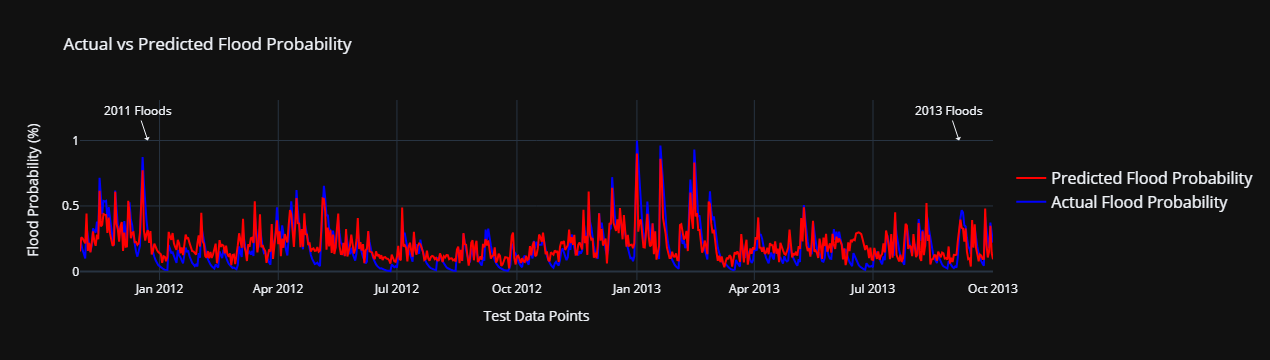

MSE: 0.007844355024197563
R2 Score: 0.6806676180185693
First 5 Predictions: [0.15256853 0.26101842 0.25240618 0.23223119 0.21439216]


In [122]:
import plotly.graph_objects as go
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you've already trained your model and have X_test, y_test ready
svr_pipeline = make_pipeline(StandardScaler(), SVR())
svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(data[features])

# Evaluating the model
mse_svr = mean_squared_error(data[target], y_pred_svr)
r2_svr = r2_score(data[target], y_pred_svr)

# Creating a plotly graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['datetime'], y=data[target].values, mode='lines', name='Actual Flood Probability', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=data['datetime'], y=y_pred_svr, mode='lines', name='Predicted Flood Probability', line=dict(color='red', width=2)))

# Adding annotations
annotations = [
    dict(x='2011-12-23', y=1, text="2011 Floods", showarrow=True, arrowhead=1),
    dict(x='2013-09-05', y=1, text="2013 Floods", showarrow=True, arrowhead=1),
    # Add more annotations here
]

# Updating layout
fig.update_layout(title='Actual vs Predicted Flood Probability',
                  xaxis_title='Test Data Points',
                  yaxis_title='Flood Probability (%)',
                  template="plotly_dark",
                  legend=dict(y=0.5, traceorder='reversed', font_size=16),
                 annotations=annotations)

fig.show()

print("MSE:", mse_svr)
print("R2 Score:", r2_svr)
print("First 5 Predictions:", y_pred_svr[:5])


<a id='Discussion'></a>
## 4. Discussion


The SVR model has shown a promising R^2 score of 0.68, indicating a decent level of variance capture for such a complex phenomenon as flood prediction. However, the MSE of 0.0078 suggests there is still room for improvement in the exactitude of the predictions. It's important to interpret these metrics correctly:

- **Mean Squared Error (MSE)** gives us the average of the squares of the errors, essentially measuring the average squared difference between the estimated values and the actual value. In the context of flood prediction, a lower MSE is desirable as it would indicate our predictions are closer to the actual flood occurrences.
- **R^2 Score**, or the coefficient of determination, explains how well the independent variables predict the variability of the dependent variable. An R^2 score of 1 indicates perfect prediction, while a score of 0 indicates the model fails to capture any predictive power.

The alignment of predicted flood probabilities with actual events is crucial for water utilities and city planners. Accurate predictions can lead to better preparedness and resource allocation for potential flood events. The model's predictive power during known flood events in 2011 and 2013 is encouraging, but further analysis is required to understand the instances of false positives and false negatives.

Potential improvements for the model could include exploring different kernel functions within the SVR framework, tuning hyperparameters more finely, or even considering ensemble methods that may capture non-linear patterns more effectively. Additionally, the incorporation of more granular temporal data or other environmental factors such as land use changes could enhance the model's predictive accuracy.

Continual refinement of predictive models is essential in the face of climate change, which is likely to increase the frequency and intensity of extreme weather events. Future iterations of this work may benefit from integrating real-time data feeds and considering long-term trends and patterns in weather data.

In summary, while the model provides a functional baseline for predicting flood events, it is clear that further refinement and research are needed to fully harness the predictive power of machine learning in flood risk management.

<a id='SaveModel'></a>
## 5. Save Model

In [124]:
from joblib import dump

# Assuming your model is named 'svr_pipeline'
dump(svr_pipeline, 'svr_pipeline_model.joblib')


['svr_pipeline_model.joblib']

<a id='CheckFeatureWeights'></a>
## 6. Check Feature Weights

In [153]:
data[svr_pipeline['standardscaler'].feature_names_in_]

,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
0,38.1,24.9,30.6,24.7,85.1,7.569,100,4.17,25.6,352.9,1007.3,86.3,9.9,111.0,9.6,4
1,36.2,25.0,28.3,24.7,88.7,0.695,100,4.17,14.2,341.9,1006.8,80.4,10.2,122.5,10.5,4
2,33.9,25.6,28.9,24.5,87.3,1.910,100,8.33,15.1,353.9,1007.2,86.1,9.9,120.3,10.3,4
3,33.3,24.7,27.4,24.3,88.6,1.389,100,8.33,12.9,303.8,1008.9,90.8,10.4,104.3,9.0,4
4,37.0,24.9,30.6,24.1,81.2,0.000,0,0.00,16.0,230.3,1009.0,87.2,10.5,157.0,13.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,36.1,25.7,31.8,23.8,76.7,0.000,0,0.00,17.1,210.2,1010.8,86.5,9.8,128.3,11.3,4
697,37.4,29.9,33.0,23.9,75.7,0.000,0,0.00,14.1,319.5,1009.3,86.0,9.5,189.9,16.4,8
698,37.0,22.9,30.9,23.4,77.5,28.824,100,8.33,21.1,267.4,1008.2,87.2,8.9,187.0,16.0,6
699,36.0,25.0,30.8,23.6,78.0,1.706,100,16.67,19.5,210.3,1008.0,88.1,9.2,167.1,14.5,6
